# Temporal and spatial mismatch vs $t_0$: Angle-averaged mismatch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from qnmfits.spatial_mapping_functions import *

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]

sims = []

for lev, R in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=R)
        sims.append(sim)
    except:
        pass

In [3]:
l_max = 8
n_max = 7

In [4]:
t0_array = np.linspace(-30, 100, 100)

mode_list = [
    [(lam, mu, n, p) for lam in np.arange(2, l_max + 1) for mu in np.arange(-lam, lam + 1) for n in np.arange(0, N + 1) for p in (-1, +1)]
    for N in range(0, n_max + 1)
]

In [5]:
mm_array = np.zeros((len(mode_list), len(t0_array)))

for i, modes in enumerate(mode_list):

    mm_list = qnmfits.mismatch_t0_array(
        sim_main.times,
        sim_main.h,
        modes,
        Mf=sim_main.Mf,
        chif=sim_main.chif_mag,
        t0_array=t0_array,
    )

    mm_array[i] = mm_list

In [6]:
mm_array_2 = np.zeros((len(mode_list), len(t0_array)))

spherical_modes = [(l, m) for l in np.arange(2, l_max + 1) for m in np.arange(-l, l + 1) if m != 0]

for i, modes in enumerate(mode_list):

    mm_list = qnmfits.mismatch_t0_array(
        sim_main.times,
        sim_main.h,
        modes,
        Mf=sim_main.Mf,
        chif=sim_main.chif_mag,
        t0_array=t0_array,
        spherical_modes=spherical_modes,
    )

    mm_array_2[i] = mm_list

In [7]:
for i, sim in enumerate(sims):
    shifts = np.arange(-0.1, 0.1, 0.0001)
    shift_idx = np.argmin([data_mismatch(sim_main, sim, modes=[(2, 2)], shift=s) for s in shifts])
    sims[i].zero_time = -shifts[shift_idx]
    sims[i].time_shift()

hsm_list = np.zeros((len(t0_array)))
for i, t0 in enumerate(t0_array):
    for sim in sims:
        hsm = data_mismatch(sim_main, sim, modes=[(2, 2)], t0=t0)
        if hsm > hsm_list[i]:
            hsm_list[i] = hsm

/tmp/ipykernel_1962551/3183204272.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap("viridis", n_max + 1)


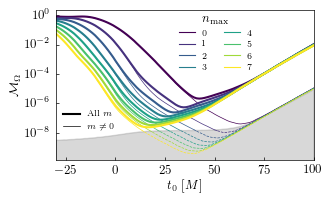

In [8]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height), ncols=1, nrows=1, sharex=True)
colors1 = plt.cm.get_cmap("viridis", n_max + 1)

for i, modes in enumerate(mode_list):

    line_error_index = np.less(hsm_list, mm_array[i])
    first_false_index = np.argmax(~line_error_index)

    if not np.all(line_error_index):
        line_error_index[first_false_index:] = False

    ax.plot(
        t0_array[line_error_index],
        mm_array[i][line_error_index],
        label=f"${modes[-1][-2]}$",
        color=colors1(i),
        linewidth=1.5,
    )
    ax.plot(
        t0_array[first_false_index - 1 : first_false_index + 1],
        mm_array[i][first_false_index - 1 : first_false_index + 1],
        color=colors1(i),
        linestyle="--",
        linewidth=1.5,
    )
    ax.plot(
        t0_array[~line_error_index],
        mm_array[i][~line_error_index],
        color=colors1(i),
        linestyle="--",
        linewidth=1.5,
    )

    line_error_index = np.less(hsm_list, mm_array_2[i])
    first_false_index = np.argmax(~line_error_index)

    if not np.all(line_error_index):
        line_error_index[first_false_index:] = False

    ax.plot(
        t0_array[line_error_index],
        mm_array_2[i][line_error_index],
        label=f"${modes[-1][-2]}$",
        color=colors1(i),
        linewidth=0.5,
    )
    ax.plot(
        t0_array[first_false_index - 1 : first_false_index + 1],
        mm_array_2[i][first_false_index - 1 : first_false_index + 1],
        color=colors1(i),
        linestyle="--",
        linewidth=0.5,
    )
    ax.plot(
        t0_array[~line_error_index],
        mm_array_2[i][~line_error_index],
        color=colors1(i),
        linestyle="--",
        linewidth=0.5,
    )

ax.fill_between(t0_array, hsm_list, color="grey", alpha=0.3)

ax.set_yscale("log")
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel("$t_0 \ [M]$")
ax.set_ylabel("$\mathcal{M}_\Omega$")

# Add legend for colors
color_legend_handles = [plt.Line2D([], [], color=colors1(i), linewidth=0.8, label=f"${modes[-1][-2]}$") for i, modes in enumerate(mode_list)]
color_legend = ax.legend(
    handles=color_legend_handles,
    frameon=False,
    fontsize=6,
    loc="upper right",
    title=r"$n_{\mathrm{max}}$",
    bbox_to_anchor=(0.79, 1.02),
    ncol=2,
)

# Add legend for line thicknesses
thick_line = plt.Line2D([], [], color="black", linewidth=1.5, linestyle="-", label=r"All $m$")
thin_line = plt.Line2D([], [], color="black", linewidth=0.5, linestyle="-", label=r"$m \neq 0$")
ax.legend(
    handles=[thick_line, thin_line],
    frameon=False,
    fontsize=6,
    loc="lower left",
    bbox_to_anchor=(0, 0.15),
)

ax.add_artist(color_legend)

fig.savefig("figs/aa_mismatch_t0.pdf", bbox_inches="tight")